In [2]:
# imports
import pandas as pd
import seaborn as sns
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA

In [14]:
data = pd.read_csv('CP_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)
scaler = StandardScaler().fit(X_train[list_numerical])
X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])


reg = Lasso(alpha=1)
reg.fit(X_train, y_train)

# R^2 results
print('R squared training set', round(reg.score(X_train, y_train)*100, 2))
print('R squared test set', round(reg.score(X_test, y_test)*100, 2))

# Training data
pred_train = reg.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))

# Test data
pred = reg.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))

R squared training set 0.0
R squared test set -0.15
MSE training set 0.09
MSE test set 0.1


/var/folders/5h/fmmpw8js0x33q9xzkn0b94z00000gn/T/ipykernel_14729/2977854018.py:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lr.fit(X_train,y_train)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.055e+01, tolerance: 7.730e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklear

[0.07588357 0.08054944 0.0851783  0.08678635 0.08875868 0.09005053
 0.10308982 0.10308982 0.10308982 0.10308982 0.10308982]


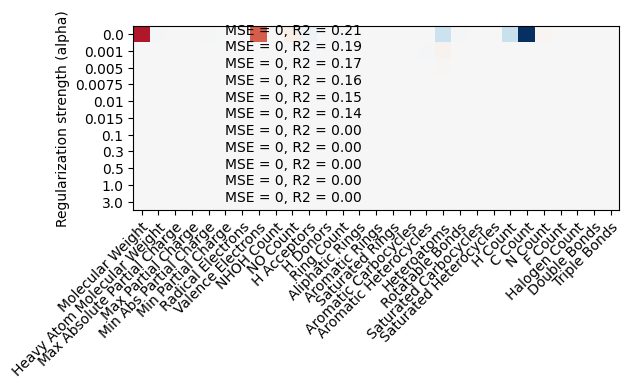

In [15]:
data_labels = list_numerical

alphas = np.array([0, 0.001, 0.005, 0.0075, 0.01, 0.015, 0.1, 0.3, 0.5, 1, 3])
y_pred = np.zeros((alphas.shape[0],y_test.shape[0]))
coeffs = np.zeros((alphas.shape[0],y.shape[0],X.shape[1]),dtype = float)
MSEs = np.zeros(alphas.shape[0])
R2s = np.zeros(alphas.shape[0])
perm_imp = np.zeros((alphas.shape[0],y.shape[0],len(data_labels)))

#Divide into train and test set
for j in range(len(alphas)):

    lr = Lasso(alpha = alphas[j], max_iter=100000) #default = 1000
    lr.fit(X_train,y_train)
    y_pred[j] = lr.predict(X_test)
    coeffs[j] = lr.coef_
    MSEs[j] = mean_squared_error(y_test,y_pred[j])
    R2s[j]  = lr.score(X_train, y_train)

#Plot the results
print(MSEs)
best = 0
for i in range(len(MSEs)):
    if MSEs[i] < MSEs[best]:
        best = i
"""
fig, ax = plt.subplots()
ax.scatter(y, y_pred[best])
ax.plot([0,15],[0,15],color='gray')
ax.annotate("MSE = {:.0f}, R2 = {:.2f}".format(MSEs[best],R2s[best]), xy=(10,20),size=20)
#ax.text(20,10,gpr.kernel_)
ax.set_ylabel("Predicted T80");
ax.set_xlabel("Actual T80");
fig.savefig("Predictions.png")
plt.show()
"""
##Print a 2D plot of the average coefficients
#matplotlib.rcParams['font.size'] = 14.0
ave_coeffs = np.average(coeffs, axis = 1)
min_coeff = np.amin(ave_coeffs)
max_coeff = np.amax(ave_coeffs)
if -min_coeff > max_coeff:
    vmax = -min_coeff
else:
    vmax = max_coeff
fig, ax = plt.subplots()#figsize=(6,3))
im = ax.imshow(ave_coeffs, interpolation="nearest", cmap="RdBu_r",vmax=vmax,vmin=-vmax)
ax.set_xticks(np.arange(len(data_labels)), labels=data_labels)
ax.set_yticks(np.arange(len(alphas)), labels=alphas)
#ax.set_xlabel('')
ax.set_ylabel('Regularization strength (alpha)')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for j in range(len(MSEs)):
    ax.text(5,j,"MSE = {:.0f}, R2 = {:.2f}".format(MSEs[j],R2s[j]))
fig.tight_layout()
fig.savefig("NF_LUMOPlot.png")
plt.show()

/var/folders/5h/fmmpw8js0x33q9xzkn0b94z00000gn/T/ipykernel_46884/905808840.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lr.fit(X_train,y_train)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.394e+01, tolerance: 7.730e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn

[0.08782071 0.08942387 0.09027656 0.09060156 0.09096491 0.09156574
 0.10308982 0.10308982 0.10308982 0.10308982 0.10308982]


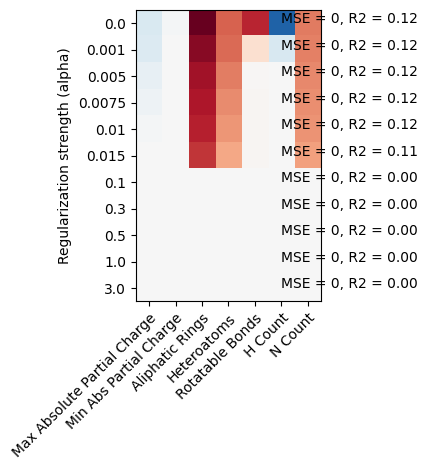

In [4]:
data = pd.read_csv('CP_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Max Absolute Partial Charge', 'Min Abs Partial Charge', 'Aliphatic Rings', 'Heteroatoms', 
                 'Rotatable Bonds', 'H Count', 'N Count']]
list_numerical = X.columns

data_labels = list_numerical

alphas = np.array([0, 0.001, 0.005, 0.0075, 0.01, 0.015, 0.1, 0.3, 0.5, 1, 3])
y_pred = np.zeros((alphas.shape[0],y_test.shape[0]))
coeffs = np.zeros((alphas.shape[0],y.shape[0],X.shape[1]),dtype = float)
MSEs = np.zeros(alphas.shape[0])
R2s = np.zeros(alphas.shape[0])
perm_imp = np.zeros((alphas.shape[0],y.shape[0],len(data_labels)))

#Divide into train and test set
for j in range(len(alphas)):

    lr = Lasso(alpha = alphas[j], max_iter=100000) #default = 1000
    lr.fit(X_train,y_train)
    y_pred[j] = lr.predict(X_test)
    coeffs[j] = lr.coef_
    MSEs[j] = mean_squared_error(y_test,y_pred[j])
    R2s[j]  = lr.score(X_train, y_train)

#Plot the results
print(MSEs)
best = 0
for i in range(len(MSEs)):
    if MSEs[i] < MSEs[best]:
        best = i
"""
fig, ax = plt.subplots()
ax.scatter(y, y_pred[best])
ax.plot([0,15],[0,15],color='gray')
ax.annotate("MSE = {:.0f}, R2 = {:.2f}".format(MSEs[best],R2s[best]), xy=(10,20),size=20)
#ax.text(20,10,gpr.kernel_)
ax.set_ylabel("Predicted T80");
ax.set_xlabel("Actual T80");
fig.savefig("Predictions.png")
plt.show()
"""
##Print a 2D plot of the average coefficients
#matplotlib.rcParams['font.size'] = 14.0
ave_coeffs = np.average(coeffs, axis = 1)
min_coeff = np.amin(ave_coeffs)
max_coeff = np.amax(ave_coeffs)
if -min_coeff > max_coeff:
    vmax = -min_coeff
else:
    vmax = max_coeff
fig, ax = plt.subplots()#figsize=(6,3))
im = ax.imshow(ave_coeffs, interpolation="nearest", cmap="RdBu_r",vmax=vmax,vmin=-vmax)
ax.set_xticks(np.arange(len(data_labels)), labels=data_labels)
ax.set_yticks(np.arange(len(alphas)), labels=alphas)
#ax.set_xlabel('')
ax.set_ylabel('Regularization strength (alpha)')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for j in range(len(MSEs)):
    ax.text(5,j,"MSE = {:.0f}, R2 = {:.2f}".format(MSEs[j],R2s[j]))
fig.tight_layout()
fig.savefig("CP_LUMOPlot_FI.png")
plt.show()

In [16]:
data = pd.read_csv('CP_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-HOMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)
scaler = StandardScaler().fit(X_train[list_numerical])
X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])


reg = Lasso(alpha=1)
reg.fit(X_train, y_train)

# R^2 results
print('R squared training set', round(reg.score(X_train, y_train)*100, 2))
print('R squared test set', round(reg.score(X_test, y_test)*100, 2))

# Training data
pred_train = reg.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))

# Test data
pred = reg.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))

R squared training set 0.0
R squared test set -4.64
MSE training set 0.05
MSE test set 0.07


/var/folders/5h/fmmpw8js0x33q9xzkn0b94z00000gn/T/ipykernel_14729/4067771302.py:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lr.fit(X_train,y_train)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.792e+01, tolerance: 4.099e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklear

[0.05829806 0.05929149 0.06148654 0.06248849 0.06362856 0.06654005
 0.06848598 0.06848598 0.06848598 0.06848598 0.06848598]


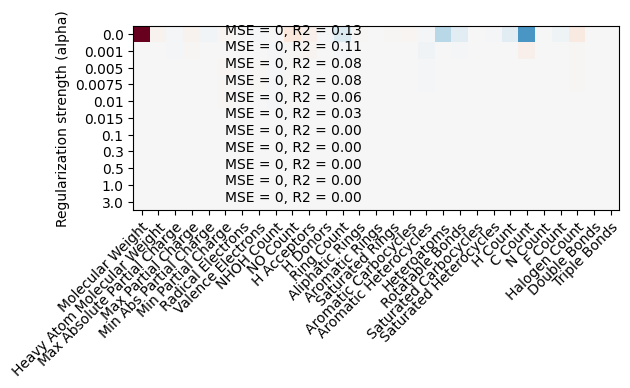

In [17]:
data_labels = list_numerical

alphas = np.array([0, 0.001, 0.005, 0.0075, 0.01, 0.015, 0.1, 0.3, 0.5, 1, 3])
y_pred = np.zeros((alphas.shape[0],y_test.shape[0]))
coeffs = np.zeros((alphas.shape[0],y.shape[0],X.shape[1]),dtype = float)
MSEs = np.zeros(alphas.shape[0])
R2s = np.zeros(alphas.shape[0])
perm_imp = np.zeros((alphas.shape[0],y.shape[0],len(data_labels)))

#Divide into train and test set
for j in range(len(alphas)):

    lr = Lasso(alpha = alphas[j], max_iter=100000) #default = 1000
    lr.fit(X_train,y_train)
    y_pred[j] = lr.predict(X_test)
    coeffs[j] = lr.coef_
    MSEs[j] = mean_squared_error(y_test,y_pred[j])
    R2s[j]  = lr.score(X_train, y_train)

#Plot the results
print(MSEs)
best = 0
for i in range(len(MSEs)):
    if MSEs[i] < MSEs[best]:
        best = i
"""
fig, ax = plt.subplots()
ax.scatter(y, y_pred[best])
ax.plot([0,15],[0,15],color='gray')
ax.annotate("MSE = {:.0f}, R2 = {:.2f}".format(MSEs[best],R2s[best]), xy=(10,20),size=20)
#ax.text(20,10,gpr.kernel_)
ax.set_ylabel("Predicted T80");
ax.set_xlabel("Actual T80");
fig.savefig("Predictions.png")
plt.show()
"""
##Print a 2D plot of the average coefficients
#matplotlib.rcParams['font.size'] = 14.0
ave_coeffs = np.average(coeffs, axis = 1)
min_coeff = np.amin(ave_coeffs)
max_coeff = np.amax(ave_coeffs)
if -min_coeff > max_coeff:
    vmax = -min_coeff
else:
    vmax = max_coeff
fig, ax = plt.subplots()#figsize=(6,3))
im = ax.imshow(ave_coeffs, interpolation="nearest", cmap="RdBu_r",vmax=vmax,vmin=-vmax)
ax.set_xticks(np.arange(len(data_labels)), labels=data_labels)
ax.set_yticks(np.arange(len(alphas)), labels=alphas)
#ax.set_xlabel('')
ax.set_ylabel('Regularization strength (alpha)')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for j in range(len(MSEs)):
    ax.text(5,j,"MSE = {:.0f}, R2 = {:.2f}".format(MSEs[j],R2s[j]))
fig.tight_layout()
fig.savefig("NF_HOMOPlot.png")
plt.show()

/var/folders/5h/fmmpw8js0x33q9xzkn0b94z00000gn/T/ipykernel_46884/68281504.py:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lr.fit(X_train,y_train)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.964e+01, tolerance: 4.099e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.

[0.06555333 0.06600982 0.06697911 0.06741991 0.06792032 0.0684909
 0.06848598 0.06848598 0.06848598 0.06848598 0.06848598]


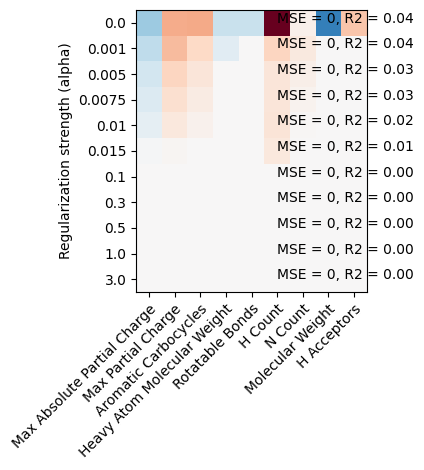

In [7]:
data = pd.read_csv('CP_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-HOMO(eV)']
X = data.loc[:, ['Max Absolute Partial Charge', 'Max Partial Charge', 'Aromatic Carbocycles', 'Heavy Atom Molecular Weight', 
                 'Rotatable Bonds', 'H Count', 'N Count', 'Molecular Weight', 'H Acceptors']]
list_numerical = X.columns

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)
scaler = StandardScaler().fit(X_train[list_numerical])
X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])


data_labels = list_numerical

alphas = np.array([0, 0.001, 0.005, 0.0075, 0.01, 0.015, 0.1, 0.3, 0.5, 1, 3])
y_pred = np.zeros((alphas.shape[0],y_test.shape[0]))
coeffs = np.zeros((alphas.shape[0],y.shape[0],X.shape[1]),dtype = float)
MSEs = np.zeros(alphas.shape[0])
R2s = np.zeros(alphas.shape[0])
perm_imp = np.zeros((alphas.shape[0],y.shape[0],len(data_labels)))

#Divide into train and test set
for j in range(len(alphas)):

    lr = Lasso(alpha = alphas[j], max_iter=100000) #default = 1000
    lr.fit(X_train,y_train)
    y_pred[j] = lr.predict(X_test)
    coeffs[j] = lr.coef_
    MSEs[j] = mean_squared_error(y_test,y_pred[j])
    R2s[j]  = lr.score(X_train, y_train)

#Plot the results
print(MSEs)
best = 0
for i in range(len(MSEs)):
    if MSEs[i] < MSEs[best]:
        best = i
"""
fig, ax = plt.subplots()
ax.scatter(y, y_pred[best])
ax.plot([0,15],[0,15],color='gray')
ax.annotate("MSE = {:.0f}, R2 = {:.2f}".format(MSEs[best],R2s[best]), xy=(10,20),size=20)
#ax.text(20,10,gpr.kernel_)
ax.set_ylabel("Predicted T80");
ax.set_xlabel("Actual T80");
fig.savefig("Predictions.png")
plt.show()
"""
##Print a 2D plot of the average coefficients
#matplotlib.rcParams['font.size'] = 14.0
ave_coeffs = np.average(coeffs, axis = 1)
min_coeff = np.amin(ave_coeffs)
max_coeff = np.amax(ave_coeffs)
if -min_coeff > max_coeff:
    vmax = -min_coeff
else:
    vmax = max_coeff
fig, ax = plt.subplots()#figsize=(6,3))
im = ax.imshow(ave_coeffs, interpolation="nearest", cmap="RdBu_r",vmax=vmax,vmin=-vmax)
ax.set_xticks(np.arange(len(data_labels)), labels=data_labels)
ax.set_yticks(np.arange(len(alphas)), labels=alphas)
#ax.set_xlabel('')
ax.set_ylabel('Regularization strength (alpha)')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for j in range(len(MSEs)):
    ax.text(5,j,"MSE = {:.0f}, R2 = {:.2f}".format(MSEs[j],R2s[j]))
fig.tight_layout()
fig.savefig("CP_HOMOPlot_FI.png")
plt.show()

In [18]:
#Step-1
X_meaned = StandardScaler().fit_transform(X)

#Step-2
cov_mat = np.cov(X_meaned , rowvar = False)

#Step-3
eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)

#Step-4
sorted_index = np.argsort(eigen_values)[::-1]
sorted_eigenvalue = eigen_values[sorted_index] # sort eigenvectors -> most important on top (pc1, pc2)
sorted_eigenvectors = eigen_vectors[:,sorted_index] # match eigenvalues to eigenvectors

#Step-5
eigenvector_subset = sorted_eigenvectors[:,0:2]

#Step-6
X_reduced = np.dot(eigenvector_subset.transpose() , X_meaned.transpose() ).transpose()

In [19]:
sort_idx = np.argsort(abs(sorted_eigenvectors))[::-1] # sort by most important features
for line in sort_idx:
    print(*line)

24 25 22 28 27 23 26 21 20 19 12 18 16 1 0 17 3 11 13 14 2 10 15 5 6 4 9 7 8
24 27 23 25 22 21 28 26 20 19 8 15 18 0 7 16 12 6 17 9 14 3 5 4 13 2 10 1 11
24 25 23 27 22 21 26 28 20 9 16 12 19 15 1 11 0 5 13 14 17 8 10 3 7 4 2 6 18
24 26 22 21 23 25 27 28 16 9 12 19 1 20 11 0 5 15 13 8 10 14 17 3 7 4 2 6 18
24 27 23 25 22 21 28 26 18 14 20 16 19 17 2 15 11 5 1 4 0 3 10 13 6 8 9 7 12
24 25 23 22 27 21 26 28 7 4 1 12 14 8 3 11 5 10 20 13 18 6 2 9 16 15 0 17 19
24 22 21 23 26 25 27 1 12 3 6 8 11 4 13 28 5 19 18 10 16 20 7 2 15 14 0 9 17
28 20 19 18 24 17 16 14 0 12 4 10 15 7 27 13 26 11 8 23 9 1 6 2 25 21 3 5 22
18 0 1 2 4 6 9 3 13 5 8 7 12 11 10 16 15 14 17 19 28 20 27 26 21 22 25 23 24
24 27 23 25 22 21 28 26 20 19 1 13 18 11 3 12 16 5 8 6 4 2 10 17 7 0 9 14 15
24 22 26 23 21 25 27 28 8 17 18 7 16 3 5 11 20 1 6 4 9 19 12 2 10 0 13 15 14
28 20 24 19 18 16 25 14 17 9 15 27 1 5 22 8 10 11 2 23 3 4 0 7 21 6 12 13 26
28 20 24 19 18 5 8 16 25 2 14 11 27 17 1 15 7 22 0 3 23 13 9 12 10 21 4 6 26

In [20]:
from sklearn.decomposition import PCA

y = data['-LUMO(eV)']
# y = energy
list_numerical = X.columns

pca = PCA(n_components = 2)

X = StandardScaler().fit_transform(X)

principal_comp = pca.fit_transform(X)

principal_df = pd.DataFrame(data = principal_comp, columns = ['principal component 1', 'principal component 2'])

final_df = pd.concat([principal_df, y], axis = 1)

explained_variance = pca.explained_variance_ratio_

explained_variance

array([0.33728933, 0.13424937])

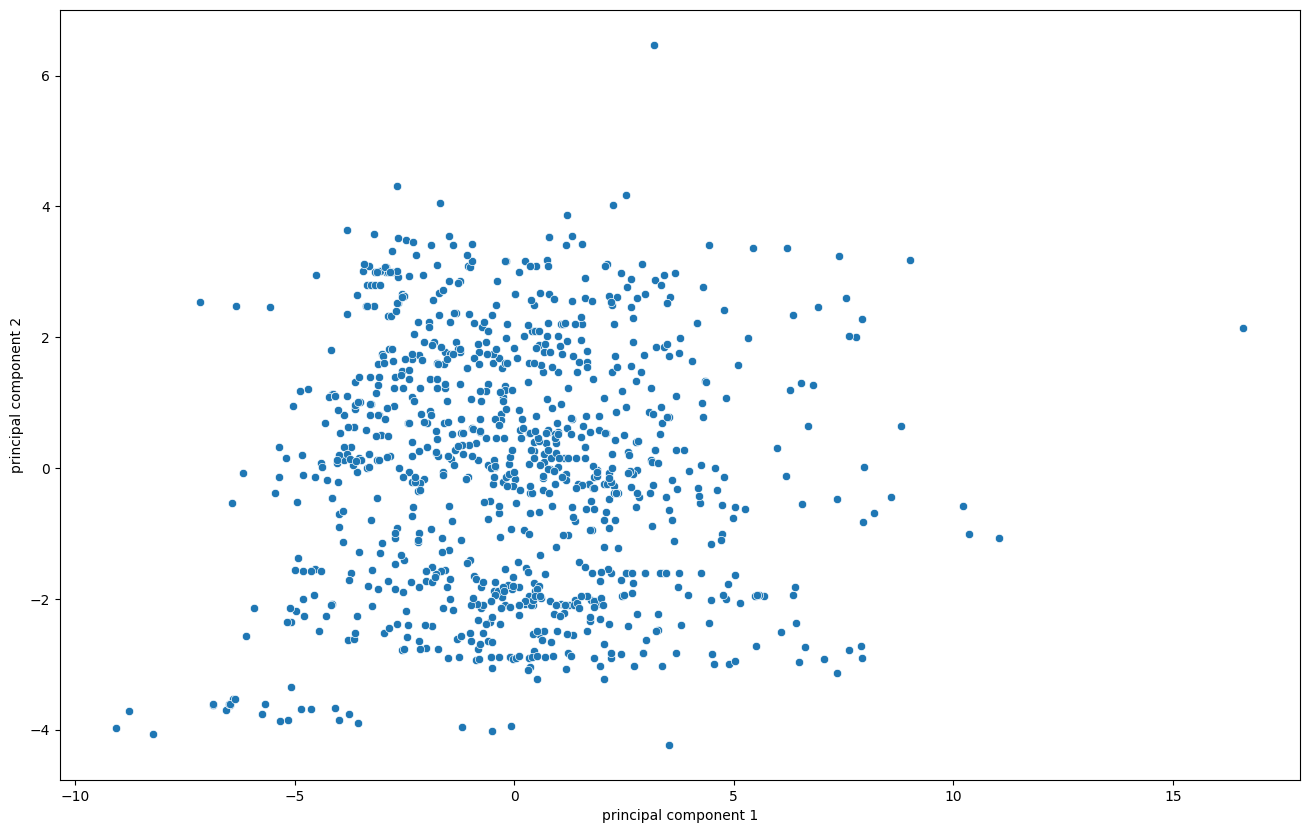

In [22]:
import seaborn as sns

plt.figure(figsize=(16,10))
g = sns.scatterplot(
    x="principal component 1", y="principal component 2", data = final_df
)
figure = g.get_figure()
figure.savefig('CPDataPCA.png', dpi=800)

In [23]:
from sklearn.decomposition import PCA

y = data['-LUMO(eV)']
X = data.loc[:,['F Count', 'Halogen Count', 'Triple Bonds', 'Saturated Carbocycles', 'H Count']]
# y = energy
list_numerical = X.columns

pca = PCA(n_components = 2)

X = StandardScaler().fit_transform(X)

principal_comp = pca.fit_transform(X)

principal_df = pd.DataFrame(data = principal_comp, columns = ['principal component 1', 'principal component 2'])

final_df = pd.concat([principal_df, y], axis = 1)

explained_variance = pca.explained_variance_ratio_

explained_variance

array([0.50077285, 0.25021862])

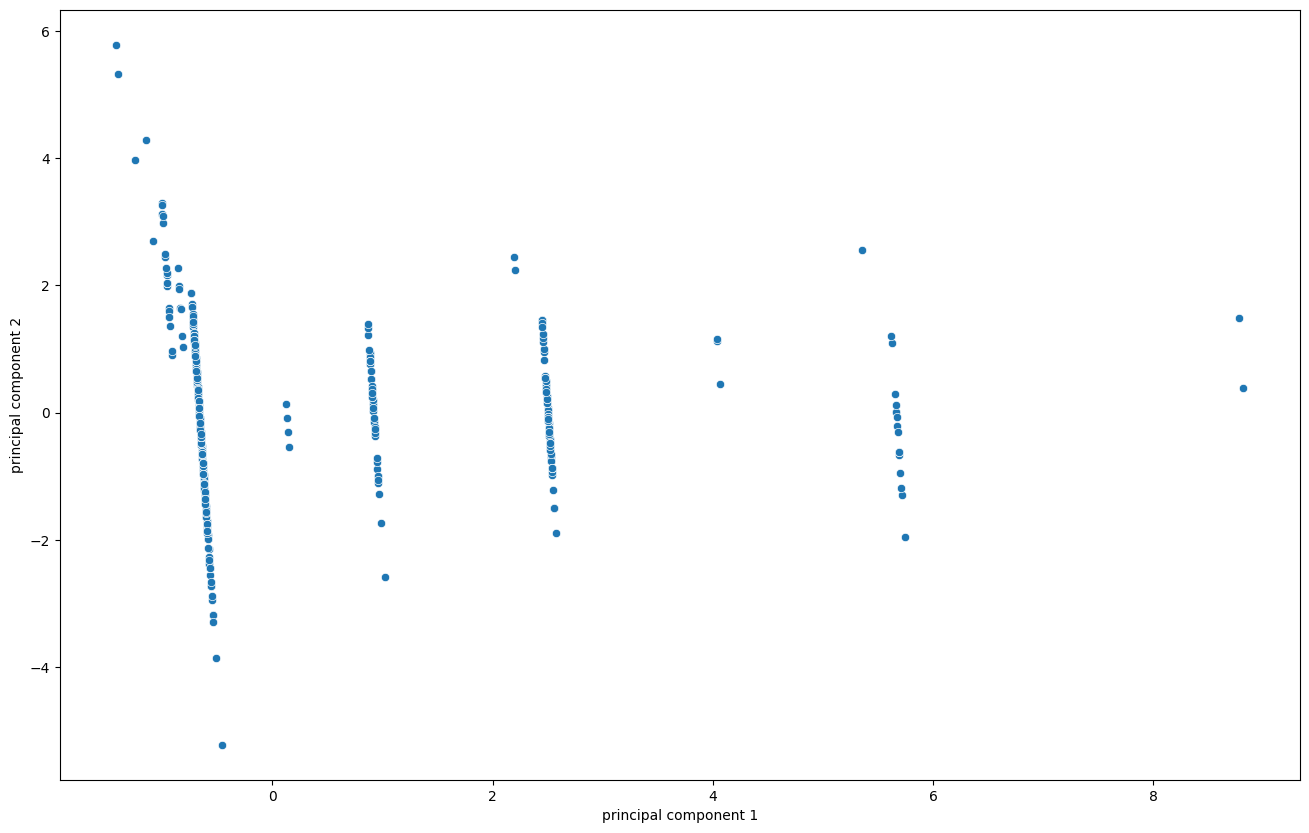

In [24]:
import seaborn as sns

plt.figure(figsize=(16,10))
g = sns.scatterplot(
    x="principal component 1", y="principal component 2", data = final_df
)
figure = g.get_figure()
figure.savefig('CPDataPCA-Top5.png', dpi=800)

In [25]:
from sklearn.decomposition import PCA

y = data['-LUMO(eV)']
X = data.loc[:,['Max Absolute Partial Charge', 'Min Abs Partial Charge', 'Aliphatic Rings', 'Heteroatoms', 'Rotatable Bonds', 'H Count', 'N Count']]
# y = energy
list_numerical = X.columns

pca = PCA(n_components = 2)

X = StandardScaler().fit_transform(X)

principal_comp = pca.fit_transform(X)

principal_df = pd.DataFrame(data = principal_comp, columns = ['principal component 1', 'principal component 2'])

final_df = pd.concat([principal_df, y], axis = 1)

explained_variance = pca.explained_variance_ratio_

explained_variance

array([0.38742475, 0.22819253])

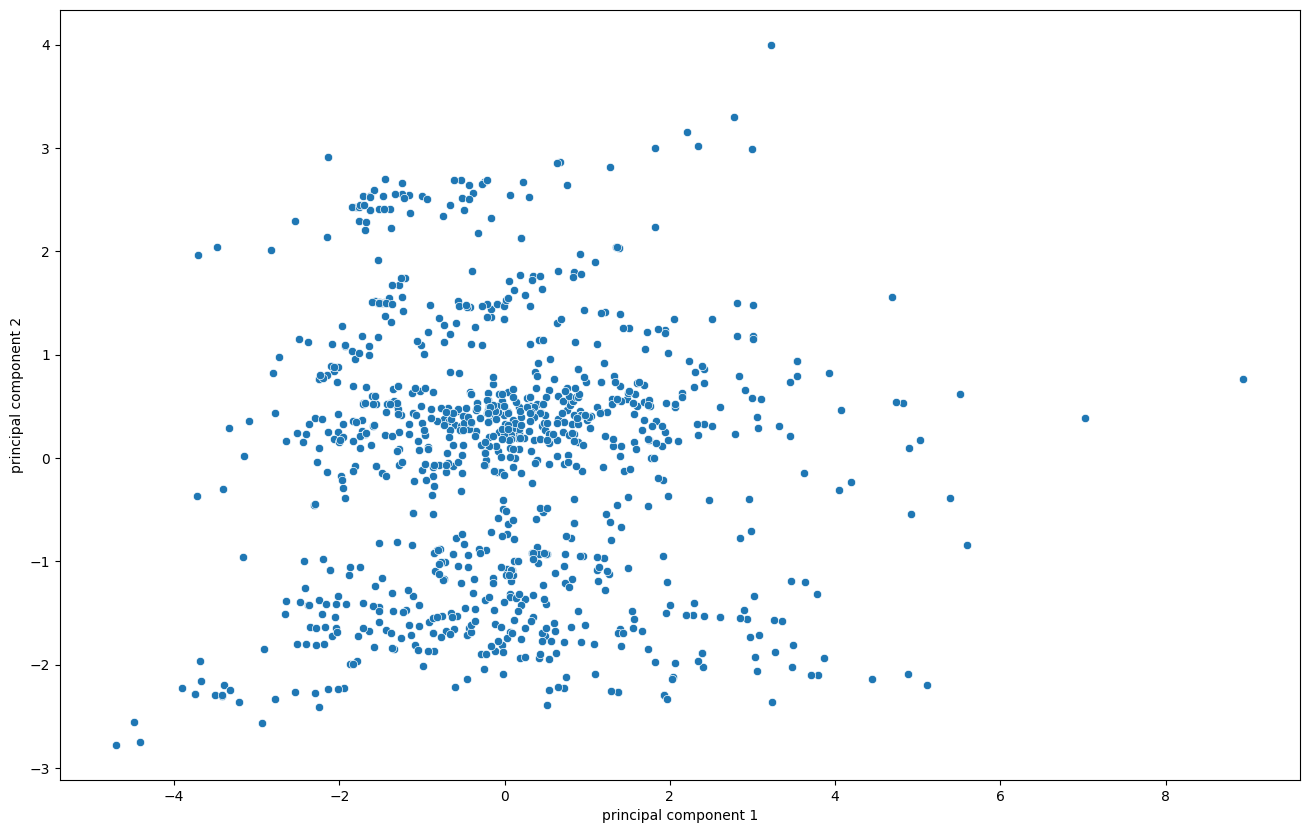

In [26]:
import seaborn as sns

plt.figure(figsize=(16,10))
g = sns.scatterplot(
    x="principal component 1", y="principal component 2", data = final_df
)
figure = g.get_figure()
figure.savefig('CPDataPCA-Top5.png', dpi=800)